Downloaded train-images-idx3-ubyte.gz to ./
Downloaded train-labels-idx1-ubyte.gz to ./
Downloaded t10k-images-idx3-ubyte.gz to ./
Downloaded t10k-labels-idx1-ubyte.gz to ./


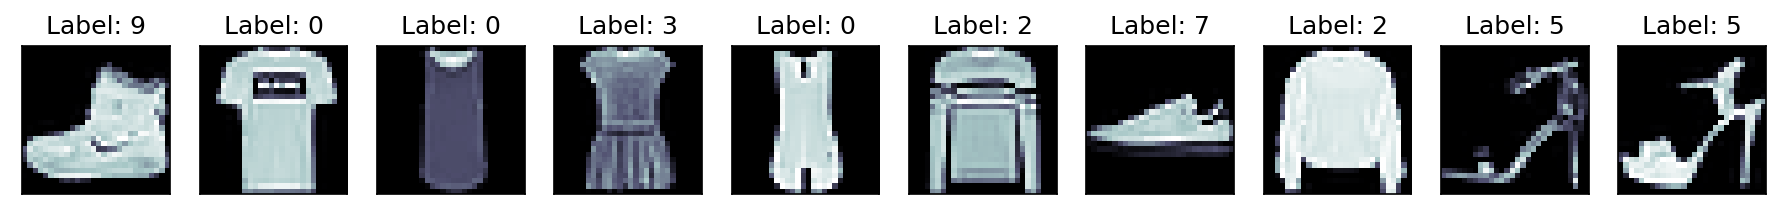

In [1]:
# Download Fashion MNIST Dataset
import gzip
import os
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import numpy as np

def fashion_mnist():
    """
    Download compressed Fashion MNIST data to local directory, and 
    unpack data into numpy arrays. 
    
    Return (train_images, train_labels, test_images, test_labels).

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']
    path = './' # Download data to current directory.
    os.makedirs(path, exist_ok=True) # Create path if it doesn't exist.

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path_):
        """Return images loaded locally."""
        with gzip.open(path_) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path_):
        """Return labels loaded locally."""
        with gzip.open(path_) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels_):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels_)
            n_cols = integer_labels_.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels_] = 1
            return onehot

        return _onehot(integer_labels)

    train_images_ = _images(os.path.join(path, files[0]))
    train_labels_ = _labels(os.path.join(path, files[1]))
    test_images_ = _images(os.path.join(path, files[2]))
    test_labels_ = _labels(os.path.join(path, files[3]))
    
    return train_images_, train_labels_, test_images_, test_labels_

train_images, train_labels, test_images, test_labels = fashion_mnist()

# Plot examples from dataset.
plt.figure(1, figsize=(15,5), dpi=150)
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(train_images[i,:].reshape(28,28), cmap='bone')
    plt.title(f'Label: {train_labels[i].argmax()}')
    plt.xticks([])
    plt.yticks([])

In [2]:
# Parts 1, 3
class NeuralNetwork:

    def __init__(self, inputs, hidden, outputs):
        """
        Initialize a simple neural network with a single hidden layer.
        This method randomly initializes the parameters of the model,
        saving them as private variables.

        Each layer is parameterized by a weight matrix and a bias vector;
        a useful trick is store the weights and biases for a layer together,
        as a single matrix.

        Args:
            inputs: int, input dimension
            hidden: int, number of hidden neurons
            outputs: int, number of output neurons
        Returns:
            None
        """
        self.z = None # hidden layer (preactivation)
        self.h = None # hidden layer (activations)
        self.w1 = np.vstack((np.random.normal(0, 1, (inputs, hidden)), np.zeros(hidden)))
        self.w2 = np.vstack((np.random.normal(0, 1, (hidden, outputs)), np.zeros(outputs)))

    @staticmethod
    def loss(y_true, y_pred):
        """
        Compute categorical cross-entropy loss function.

        Sum loss contributions over the outputs (axis=1), but
        average over the examples (axis=0)

        Args:
            y_true: NxD numpy array with N examples, D outputs (one-hot labels).
            y_pred: NxD numpy array with N examples, D outputs (probabilities).
        Returns:
            loss: array of length N representing loss for each example.
        """
        return np.sum(-((y_true * np.ma.log(y_pred)) - ((1 - y_true) * np.ma.log(1 - y_pred))), axis=1)

    def evaluate(self, X, y):
        """
        Make predictions and compute loss.
        Args:
            X: NxM numpy array where n-th row is an input.
            y: NxD numpy array with N examples and D outputs (one-hot labels).
        Returns:
            loss: array of length N representing loss for each example.
        """
        return self.loss(y, self.predict(X))

    def predict(self, X):
        """
        Make predictions on inputs X.
        Args:
            X: NxM numpy array where n-th row is an input.
        Returns:
            y_pred: NxD array where n-th row is vector of probabilities.
        """
        # Add a constant input node to each sample (for bias multiplication in w1)
        X = np.hstack((X, np.ones(X.shape[0]).reshape(-1, 1)))

        # Calculate the hidden layer weighted sums
        self.h = X @ self.w1

        # Activate the hidden layer weighted sums with ReLU
        self.h[self.h < 0] = 0

        # Add a constant hidden activation to each sample (for bias multiplication in w2)
        self.h = np.hstack((self.h, np.ones(X.shape[0]).reshape(-1, 1)))
        self.z = self.h
        self.z[self.z > 0] = 1

        # Calculate the output layer weighted sums
        y = self.h @ self.w2

        # Calculate each sample's softmax prediction probabilities for each output
        e_y = np.exp(y - np.max(y, axis=1).reshape(-1, 1))
        return e_y / np.sum(e_y, axis=1).reshape(-1, 1)

    def train(self, X, y, lr=0.0001, max_epochs=10, batch_size=100, x_val=None, y_val=None):
        """
        Train the neural network using stochastic gradient descent.

        Args:
            X: NxM numpy array where n-th row is an input.
            y: NxD numpy array with N examples and D outputs (one-hot labels).
            lr: scalar learning rate. Use small value for debugging.
            max_epochs: int, each epoch is one iteration through the train data.
            batch_size: int, size of each mini batch for training.
            x_val: numpy array containing validation data inputs.
            y_val: numpy array containing validation data outputs.
        Returns:
            history: dict with the following key, value pairs:
                     'loss' -> list containing the training loss at each epoch
                     'loss_val' -> list for the validation loss at each epoch
        """
        losses = []
        losses_val = []
        for epoch in range(max_epochs):

            X_ = X
            y_ = y

            # MINI BATCH:
            # check if there's train data left
            batch_losses = []
            while X_.shape[0] > 0:

                # setting the batch
                batch = X_[:min(batch_size, X_.shape[0])]
                y_batch = y_[:min(batch_size, y_.shape[0])]

                # predicting
                y_pred = self.predict(batch)
                batch = np.hstack((batch, np.ones(batch.shape[0]).reshape(-1, 1)))
                batch_losses.append(np.mean(self.loss(y_batch, y_pred)))

                # updating
                delta2 = y_pred - y_batch
                self.w2 -= lr * self.h.T @ delta2

                delta1 = delta2 @ self.w2.T[:,:-1] * self.z[:,:-1]
                self.w1 -= lr * batch.T @ delta1

                # removing the batch
                X_ = X_[batch_size:]
                y_ = y_[batch_size:]

            losses.append(np.mean(batch_losses))

            if (x_val is not None) and (y_val is not None):
                losses_val.append(np.mean(self.loss(y_val, self.predict(x_val))))

        return {'loss': losses, 'loss_val': losses_val}

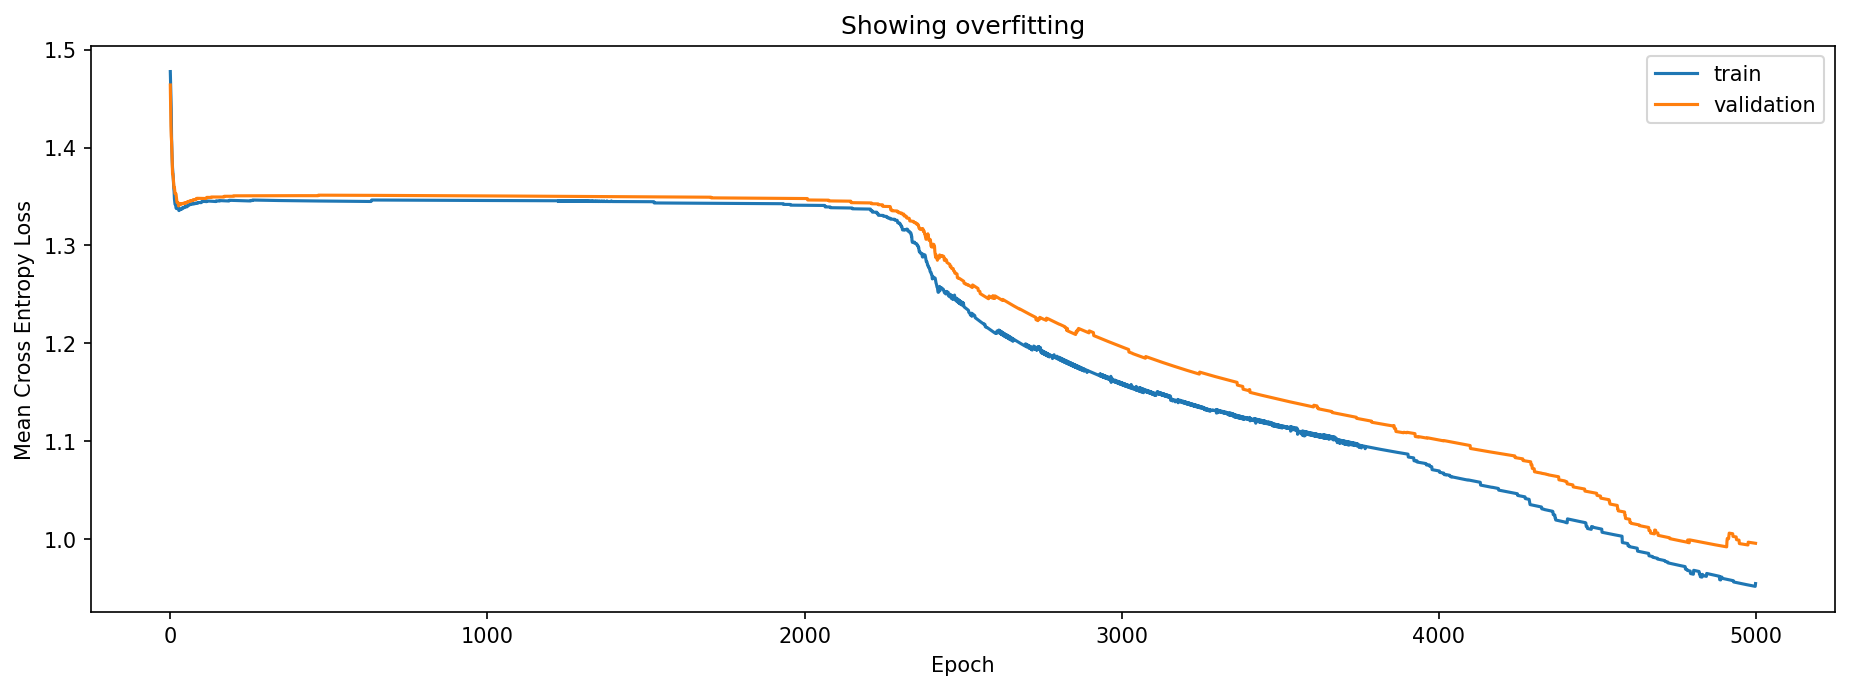

In [3]:
# Part 2.1: Overfitting is shown by the validation error increasing as the training error does not increase.

SAMPLE_SIZE = 500
MAX_EPOCHS = 5000

train_indices = np.random.choice(train_images.shape[0], size=SAMPLE_SIZE)
val_indices = np.random.choice(test_images.shape[0], size=SAMPLE_SIZE)

clf = NeuralNetwork(train_images.shape[1], 1, train_labels.shape[1])
history = clf.train(X=train_images[train_indices],
                    y=train_labels[train_indices],
                    max_epochs=MAX_EPOCHS,
                    x_val=test_images[val_indices],
                    y_val=test_labels[val_indices])

plt.figure(figsize=(15, 5), dpi=150)
plt.plot(np.arange(MAX_EPOCHS), history['loss'], label='train')

plt.plot(np.arange(MAX_EPOCHS), history['loss_val'], label='validation')
plt.title("Showing overfitting")
plt.xlabel("Epoch")
plt.ylabel("Mean Cross Entropy Loss")
plt.legend()
plt.show()

Best Performance (lowest mean cross entropy loss):
0.3543 

Best Hyperparameters:
Learning Rate:	0.0018
Hidden Neurons:	36



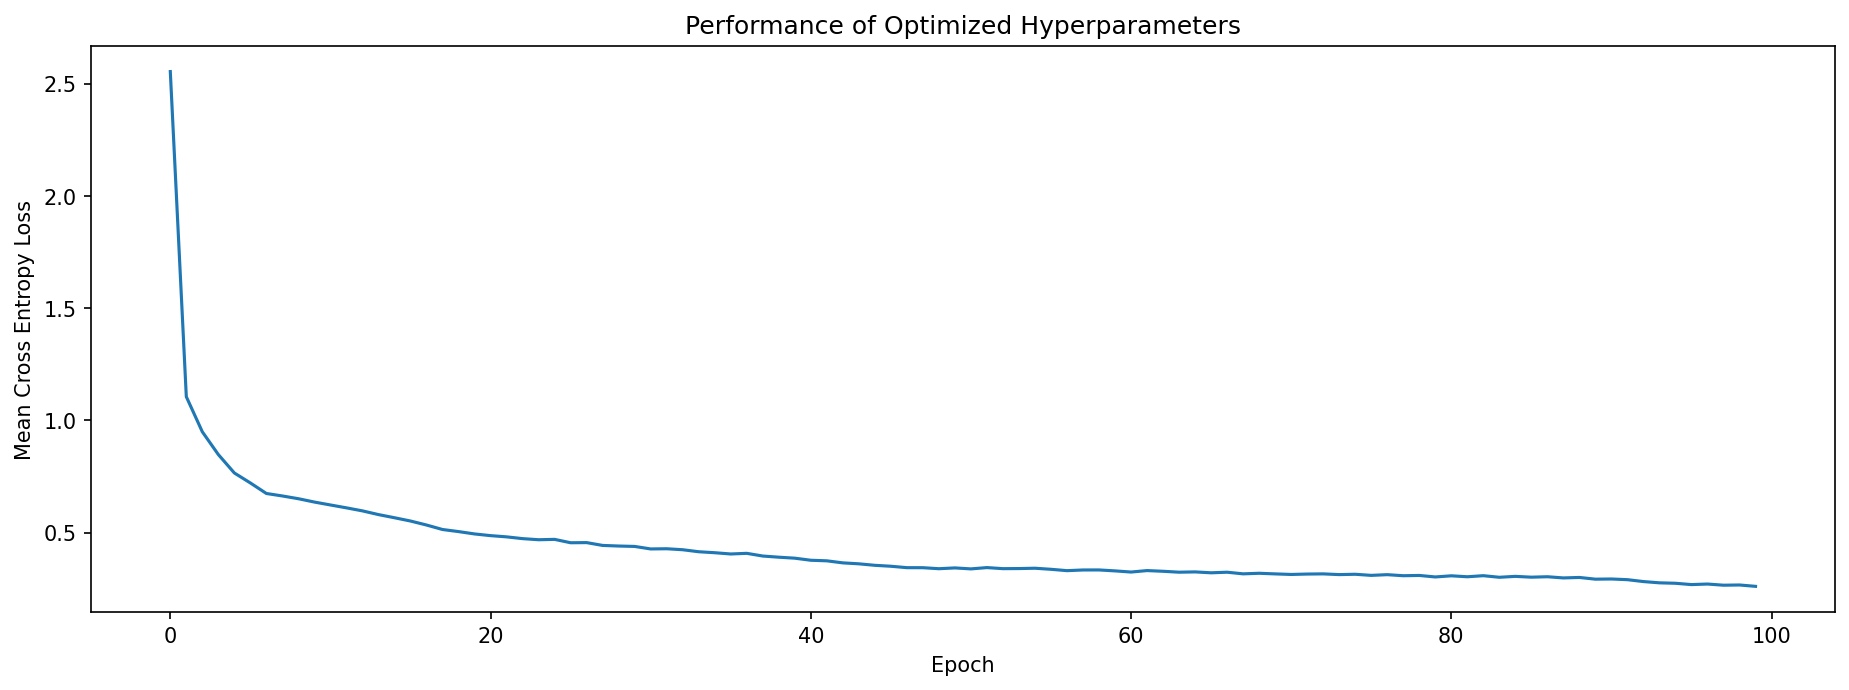

In [4]:
# Part 2.2: Hyperparameter tuning

SAMPLE_SIZE = 1000
MAX_EPOCHS = 100

train_indices = np.random.choice(train_images.shape[0], size=SAMPLE_SIZE)
test_indices = np.random.choice(test_images.shape[0], size=SAMPLE_SIZE)

LEARNING_RATES = np.arange(0.0011, 0.0021, 0.0001)
HIDDEN_NEURONS = np.arange(20, 40, 2)

histories = []
test_losses = []
performance = []

for lr_i in LEARNING_RATES:
    for hidden_i in HIDDEN_NEURONS:
        clf = NeuralNetwork(train_images.shape[1], hidden_i, train_labels.shape[1])
        histories.append(clf.train(X=train_images[train_indices],
                                   y=train_labels[train_indices],
                                   lr=lr_i,
                                   max_epochs=MAX_EPOCHS,
                                   batch_size=200))
        
        # judging optimization on the mean loss
        loss = clf.evaluate(test_images, test_labels)
        test_losses.append(loss)
        performance.append([np.mean(loss), lr_i, hidden_i])
        
performance = np.array(performance)
best_index = performance[:, 0].argmin()
best_hist = histories[best_index]
        
print(f"""Best Performance (lowest mean cross entropy loss):
{performance[best_index, 0]:.4f} 

Best Hyperparameters:
Learning Rate:\t{performance[best_index, 1]:.4f}
Hidden Neurons:\t{performance[best_index, 2]:.0f}
""")

plt.figure(figsize=(15, 5), dpi=150)
plt.plot(np.arange(MAX_EPOCHS), best_hist['loss'], label='train')
plt.title("Performance of Optimized Hyperparameters")
plt.xlabel("Epoch")
plt.ylabel("Mean Cross Entropy Loss")
plt.show()

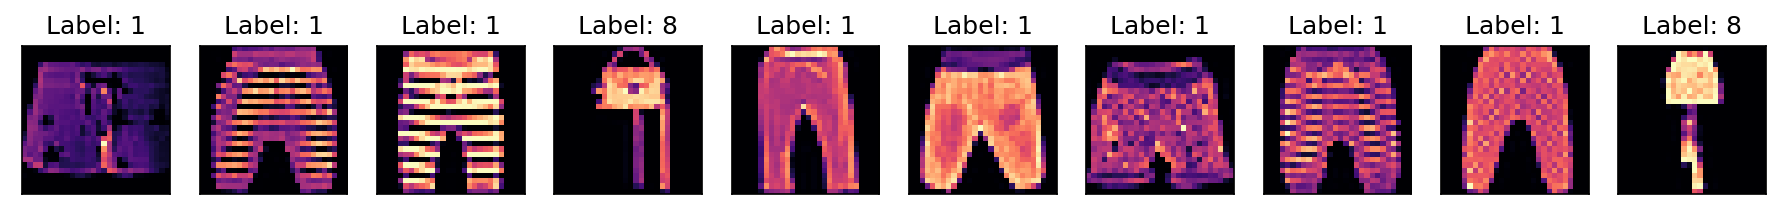

In [5]:
# Part 2.3: 10 examples with worst losses, using optimized hyperparameters

import pandas as pd

data = np.hstack((test_losses[best_index].reshape(-1, 1), test_images, test_labels))
cols = ["Loss"] + [_ for _ in range(784)] + [_ for _ in range(10)]

df = pd.DataFrame(data, columns=cols)
ar = df.sort_values("Loss", ascending=False)[:10].to_numpy()

samples = ar[:, 1:-10]
labels = ar[:, -10:]

plt.figure(1, figsize=(15,5), dpi=150)
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(samples[i].reshape(28,28), cmap='magma')
    plt.title(f'Label: {labels[i].argmax()}')
    plt.xticks([])
    plt.yticks([])